# Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models 
from PIL import ImageOps
from torchsummary import summary
from collections import Counter
import torchvision
from sklearn.model_selection import train_test_split
from PIL import Image


# Seeds

In [2]:
# For reproduce the result
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

# Some necessary settings

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)
# define class names
classes = ('Class A', 'Class B', 'Class C')
dataset_path = "./damage_classification_forTrain/column_damage"

You are using device: cuda
You are using PyTorch version: 2.5.1


# Data loading and processing

In [4]:
def load_dataset(path_dataset):
    # Data transformations for training
    
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomChoice([
            transforms.RandomCrop(224, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05)
        ]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    transform_noaug = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load dataset
    full_dataset = torchvision.datasets.ImageFolder(
        root=path_dataset,
        transform=transform_train
    )
    full_dataset_noaug = torchvision.datasets.ImageFolder(
        root=path_dataset,
        transform=transform_noaug
    )
    # 拿到所有的資料 index 和 label
    all_indices = list(range(len(full_dataset)))
    all_labels = [full_dataset[i][1] for i in range(len(full_dataset))]

    # 使用 stratify 保持類別分布一致
    train_indices, val_indices = train_test_split(
        all_indices,
        test_size=0.2,
        stratify=all_labels, 
        random_state=42        
    )
    trainset = Subset(full_dataset, train_indices)
    valset = Subset(full_dataset, val_indices)
    
    trainset.dataset.transform = transform_train
    valset.dataset.transform = transform_noaug


    train_labels = [trainset[i][1] for i in range(len(trainset))]
    val_labels = [valset[i][1] for i in range(len(valset))]

    train_counter = Counter(train_labels)
    val_counter = Counter(val_labels)

    print("\n每個類別的訓練資料數量：")
    for i in range(len(full_dataset_noaug.classes)):
        class_name = full_dataset_noaug.classes[i]
        print(f"  {class_name}: {train_counter[i]} 張")
    
    print("\n每個類別的驗證資料數量：")
    for i in range(len(full_dataset_noaug.classes)):
        class_name = full_dataset_noaug.classes[i]
        print(f"  {class_name}: {val_counter[i]} 張")

    trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
    valloader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=0)

    class_map = {i: full_dataset_noaug.classes[i] for i in range(len(full_dataset_noaug.classes))}

    print(f"Dataset classes: {class_map}")

    global classes
    if len(full_dataset_noaug.classes) == len(classes):
        print("Using predefined class names")
    else:
        print("Using classes from dataset folder structure")
        classes = full_dataset_noaug.classes

    return trainloader, valloader, full_dataset_noaug

# Load dataset
trainloader, valloader, dataset_noaug = load_dataset(dataset_path)


每個類別的訓練資料數量：
  Class A: 326 張
  Class B: 54 張
  Class C: 207 張

每個類別的驗證資料數量：
  Class A: 82 張
  Class B: 13 張
  Class C: 52 張
Dataset classes: {0: 'Class A', 1: 'Class B', 2: 'Class C'}
Using predefined class names


# Model Definition 

In [5]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

def class_model(num_classes=3, freeze_backbone=True):
    weights = ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1
    model = vit_l_16(weights=weights)

    in_features = model.heads.head.in_features

    # 自定義分類頭
    model.heads.head = nn.Sequential(
        nn.LayerNorm(in_features),
        nn.Dropout(0.5),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

    if freeze_backbone:
        # 先全部凍結
        for param in model.parameters():
            param.requires_grad = False

        # 解凍分類頭
        for param in model.heads.parameters():
            param.requires_grad = True

        # 解凍最後 3 個 encoder blocks
        encoder_blocks = model.encoder.layers  # transformer blocks
        for block in encoder_blocks[-2:]:
            for param in block.parameters():
                param.requires_grad = True

        # 解凍所有 LayerNorm 或 normalization 層
        for module in model.modules():
            if isinstance(module, (nn.LayerNorm, nn.BatchNorm2d)):
                for param in module.parameters():
                    param.requires_grad = True

    return model, weights.transforms()


# 使用方式
model, preprocess = class_model(num_classes=3, freeze_backbone=True)
model = model.to(device)


# Model Training

In [6]:
class EarlyStopping:
    def __init__(self, patience=6, delta=0.0, mode='max', verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode  # 'min' for loss, 'max' for accuracy

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif ((self.mode == 'min' and current_score > self.best_score - self.delta) or
              (self.mode == 'max' and current_score < self.best_score + self.delta)):
            self.counter += 1
            if self.verbose:
                print(f" EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("觸發 Early Stopping!")
        else:
            self.best_score = current_score
            self.counter = 0


def train(model, trainloader, valloader, epochs=10, num_classes=3, device='cuda'):
    # === 計算 class weights 並依照調整係數修正 ===
    class_counts = [0] * num_classes
    for _, label in trainloader.dataset:
        class_counts[label] += 1

    total_samples = sum(class_counts)

    # 計算初始的 class weights（越少樣本，權重越高）
    class_weights = [total_samples / c for c in class_counts]

    # 你可以在這裡手動調整每一類的權重係數（例如 class 0: 1.0, class 1: 1.1, class 2: 0.9）
    class_weight_factors = [1.0, 1.5, 1.09]

    # 套用權重調整係數
    class_weights = [w * f for w, f in zip(class_weights, class_weight_factors)]

    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # 印出資訊
    print(f"類別計數：{class_counts}")
    print(f"Class Weight Factors: {class_weight_factors}")
    print(f"最終 Class Weights: {class_weights.cpu().numpy()}")


    # 使用 class weights 的損失
    criterion = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.1)
    
    # 優化器使用 AdamW
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

    # 使用 OneCycleLR 調整學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-4,
        epochs=epochs,
        steps_per_epoch=len(trainloader),
        pct_start=0.2,         # 20% warmup
        div_factor=25,         # 初始 lr = max_lr / 25
        final_div_factor=1e4   # 結束時 lr = max_lr / 10000
    )

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=6, delta=0.001, mode='max', verbose=True)
    best_acc = 0.0  # 初始化最佳準確率

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # 優化器步驟
            optimizer.step()

            # 每個 batch 後動態調整學習率
            scheduler.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # 儲存最佳模型
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model_class.h5')
            print("保存當前最佳模型")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        # Early stopping 判斷
        early_stopping(epoch_val_acc)  # 使用準確率進行早停判斷
        if early_stopping.early_stop:
            break

    print('訓練完成')
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [7]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix

In [8]:
print("Starting training...")
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, trainloader, valloader, epochs=80
)

Starting training...
類別計數：[326, 54, 207]
Class Weight Factors: [1.0, 1.5, 1.09]
最終 Class Weights: [ 1.8006135 16.305555   3.0909662]


Epoch [1/80]: 100%|██████████| 37/37 [03:51<00:00,  6.26s/it, accuracy=24.5, loss=1.21]


保存當前最佳模型
Epoch 1/80
Train Loss: 1.2108, Train Acc: 24.53%
Val Loss: 1.2281, Val Acc: 8.84%
------------------------------------------------------------


Epoch [2/80]: 100%|██████████| 37/37 [03:50<00:00,  6.24s/it, accuracy=19.1, loss=1.17]


保存當前最佳模型
Epoch 2/80
Train Loss: 1.1727, Train Acc: 19.08%
Val Loss: 1.2030, Val Acc: 11.56%
------------------------------------------------------------


Epoch [3/80]: 100%|██████████| 37/37 [03:49<00:00,  6.20s/it, accuracy=27.4, loss=1.14]


保存當前最佳模型
Epoch 3/80
Train Loss: 1.1422, Train Acc: 27.43%
Val Loss: 1.1628, Val Acc: 16.33%
------------------------------------------------------------


Epoch [4/80]: 100%|██████████| 37/37 [03:50<00:00,  6.23s/it, accuracy=37, loss=1.08]  


保存當前最佳模型
Epoch 4/80
Train Loss: 1.0831, Train Acc: 36.97%
Val Loss: 1.1040, Val Acc: 51.02%
------------------------------------------------------------


Epoch [5/80]: 100%|██████████| 37/37 [03:51<00:00,  6.27s/it, accuracy=48, loss=0.999] 


保存當前最佳模型
Epoch 5/80
Train Loss: 0.9987, Train Acc: 48.04%
Val Loss: 0.9767, Val Acc: 76.87%
------------------------------------------------------------


Epoch [6/80]: 100%|██████████| 37/37 [03:51<00:00,  6.26s/it, accuracy=65.2, loss=0.923]


保存當前最佳模型
Epoch 6/80
Train Loss: 0.9225, Train Acc: 65.25%
Val Loss: 0.9084, Val Acc: 81.63%
------------------------------------------------------------


Epoch [7/80]: 100%|██████████| 37/37 [03:47<00:00,  6.15s/it, accuracy=77.7, loss=0.836]


Epoch 7/80
Train Loss: 0.8359, Train Acc: 77.68%
Val Loss: 0.9189, Val Acc: 81.63%
------------------------------------------------------------
 EarlyStopping counter: 1/6


Epoch [8/80]: 100%|██████████| 37/37 [03:46<00:00,  6.11s/it, accuracy=80.4, loss=0.798]


Epoch 8/80
Train Loss: 0.7975, Train Acc: 80.41%
Val Loss: 0.9860, Val Acc: 72.11%
------------------------------------------------------------
 EarlyStopping counter: 2/6


Epoch [9/80]: 100%|██████████| 37/37 [03:45<00:00,  6.10s/it, accuracy=84, loss=0.782]  


Epoch 9/80
Train Loss: 0.7819, Train Acc: 83.99%
Val Loss: 0.8698, Val Acc: 79.59%
------------------------------------------------------------
 EarlyStopping counter: 3/6


Epoch [10/80]: 100%|██████████| 37/37 [03:45<00:00,  6.10s/it, accuracy=87.9, loss=0.751]


Epoch 10/80
Train Loss: 0.7508, Train Acc: 87.90%
Val Loss: 1.0556, Val Acc: 64.63%
------------------------------------------------------------
 EarlyStopping counter: 4/6


Epoch [11/80]: 100%|██████████| 37/37 [03:45<00:00,  6.10s/it, accuracy=88.1, loss=0.673]


保存當前最佳模型
Epoch 11/80
Train Loss: 0.6727, Train Acc: 88.07%
Val Loss: 0.9279, Val Acc: 82.99%
------------------------------------------------------------


Epoch [12/80]: 100%|██████████| 37/37 [03:46<00:00,  6.13s/it, accuracy=87.9, loss=0.703]


保存當前最佳模型
Epoch 12/80
Train Loss: 0.7035, Train Acc: 87.90%
Val Loss: 0.9261, Val Acc: 85.03%
------------------------------------------------------------


Epoch [13/80]: 100%|██████████| 37/37 [03:47<00:00,  6.16s/it, accuracy=90.6, loss=0.663]


保存當前最佳模型
Epoch 13/80
Train Loss: 0.6631, Train Acc: 90.63%
Val Loss: 0.8679, Val Acc: 85.71%
------------------------------------------------------------


Epoch [14/80]: 100%|██████████| 37/37 [03:46<00:00,  6.13s/it, accuracy=95.6, loss=0.59] 


保存當前最佳模型
Epoch 14/80
Train Loss: 0.5904, Train Acc: 95.57%
Val Loss: 0.8811, Val Acc: 86.39%
------------------------------------------------------------


Epoch [15/80]: 100%|██████████| 37/37 [03:49<00:00,  6.20s/it, accuracy=96.1, loss=0.585]


Epoch 15/80
Train Loss: 0.5854, Train Acc: 96.08%
Val Loss: 0.9526, Val Acc: 85.71%
------------------------------------------------------------
 EarlyStopping counter: 1/6


Epoch [16/80]: 100%|██████████| 37/37 [03:49<00:00,  6.20s/it, accuracy=96.4, loss=0.589]


保存當前最佳模型
Epoch 16/80
Train Loss: 0.5889, Train Acc: 96.42%
Val Loss: 0.9085, Val Acc: 88.44%
------------------------------------------------------------


Epoch [17/80]: 100%|██████████| 37/37 [03:47<00:00,  6.14s/it, accuracy=95.6, loss=0.604]


Epoch 17/80
Train Loss: 0.6042, Train Acc: 95.57%
Val Loss: 1.0153, Val Acc: 84.35%
------------------------------------------------------------
 EarlyStopping counter: 1/6


Epoch [18/80]: 100%|██████████| 37/37 [03:43<00:00,  6.05s/it, accuracy=98, loss=0.562]  


Epoch 18/80
Train Loss: 0.5618, Train Acc: 97.96%
Val Loss: 1.1350, Val Acc: 82.31%
------------------------------------------------------------
 EarlyStopping counter: 2/6


Epoch [19/80]: 100%|██████████| 37/37 [03:44<00:00,  6.06s/it, accuracy=96.9, loss=0.583]


Epoch 19/80
Train Loss: 0.5830, Train Acc: 96.93%
Val Loss: 0.9213, Val Acc: 87.76%
------------------------------------------------------------
 EarlyStopping counter: 3/6


Epoch [20/80]: 100%|██████████| 37/37 [03:44<00:00,  6.06s/it, accuracy=97.4, loss=0.575]


保存當前最佳模型
Epoch 20/80
Train Loss: 0.5746, Train Acc: 97.44%
Val Loss: 0.9248, Val Acc: 89.80%
------------------------------------------------------------


Epoch [21/80]: 100%|██████████| 37/37 [03:44<00:00,  6.06s/it, accuracy=99.1, loss=0.543]


保存當前最佳模型
Epoch 21/80
Train Loss: 0.5429, Train Acc: 99.15%
Val Loss: 0.9185, Val Acc: 90.48%
------------------------------------------------------------


Epoch [22/80]: 100%|██████████| 37/37 [03:43<00:00,  6.04s/it, accuracy=99.7, loss=0.527]


Epoch 22/80
Train Loss: 0.5274, Train Acc: 99.66%
Val Loss: 0.9178, Val Acc: 89.80%
------------------------------------------------------------
 EarlyStopping counter: 1/6


Epoch [23/80]: 100%|██████████| 37/37 [03:43<00:00,  6.05s/it, accuracy=99.7, loss=0.522]


Epoch 23/80
Train Loss: 0.5220, Train Acc: 99.66%
Val Loss: 0.8880, Val Acc: 90.48%
------------------------------------------------------------
 EarlyStopping counter: 2/6


Epoch [24/80]: 100%|██████████| 37/37 [03:43<00:00,  6.04s/it, accuracy=99.5, loss=0.526]


Epoch 24/80
Train Loss: 0.5262, Train Acc: 99.49%
Val Loss: 0.9009, Val Acc: 89.12%
------------------------------------------------------------
 EarlyStopping counter: 3/6


Epoch [25/80]: 100%|██████████| 37/37 [03:47<00:00,  6.15s/it, accuracy=99, loss=0.538]  


保存當前最佳模型
Epoch 25/80
Train Loss: 0.5382, Train Acc: 98.98%
Val Loss: 0.8644, Val Acc: 91.84%
------------------------------------------------------------


Epoch [26/80]: 100%|██████████| 37/37 [03:50<00:00,  6.23s/it, accuracy=99.3, loss=0.539]


Epoch 26/80
Train Loss: 0.5392, Train Acc: 99.32%
Val Loss: 0.9243, Val Acc: 88.44%
------------------------------------------------------------
 EarlyStopping counter: 1/6


Epoch [27/80]: 100%|██████████| 37/37 [03:44<00:00,  6.06s/it, accuracy=99.5, loss=0.523]


Epoch 27/80
Train Loss: 0.5228, Train Acc: 99.49%
Val Loss: 0.9528, Val Acc: 88.44%
------------------------------------------------------------
 EarlyStopping counter: 2/6


Epoch [28/80]: 100%|██████████| 37/37 [03:47<00:00,  6.14s/it, accuracy=100, loss=0.517]


Epoch 28/80
Train Loss: 0.5174, Train Acc: 100.00%
Val Loss: 0.9376, Val Acc: 88.44%
------------------------------------------------------------
 EarlyStopping counter: 3/6


Epoch [29/80]: 100%|██████████| 37/37 [03:43<00:00,  6.05s/it, accuracy=100, loss=0.513]


Epoch 29/80
Train Loss: 0.5131, Train Acc: 100.00%
Val Loss: 0.9432, Val Acc: 88.44%
------------------------------------------------------------
 EarlyStopping counter: 4/6


Epoch [30/80]: 100%|██████████| 37/37 [03:43<00:00,  6.04s/it, accuracy=100, loss=0.522]


Epoch 30/80
Train Loss: 0.5217, Train Acc: 100.00%
Val Loss: 0.9312, Val Acc: 88.44%
------------------------------------------------------------
 EarlyStopping counter: 5/6


Epoch [31/80]: 100%|██████████| 37/37 [03:43<00:00,  6.05s/it, accuracy=100, loss=0.525]


Epoch 31/80
Train Loss: 0.5246, Train Acc: 100.00%
Val Loss: 0.9257, Val Acc: 89.12%
------------------------------------------------------------
 EarlyStopping counter: 6/6
觸發 Early Stopping!
訓練完成


# Training Result Visualization

In [9]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [10]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return

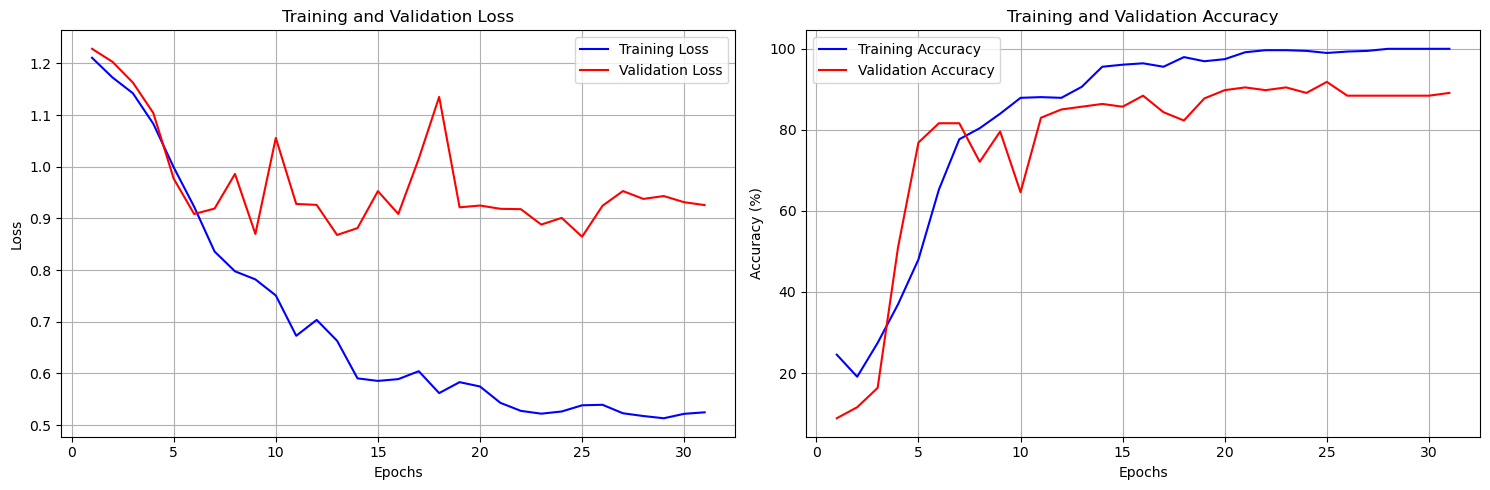

Training metrics plot saved as 'training_metrics.png'


In [11]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

Starting evaluating...


Evaluating: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]

Overall Accuracy: 89.12%

Per-class Accuracy:
--------------------------------------------------
Class A: 93.90% (77/82)
Class B: 46.15% (6/13)
Class C: 92.31% (48/52)


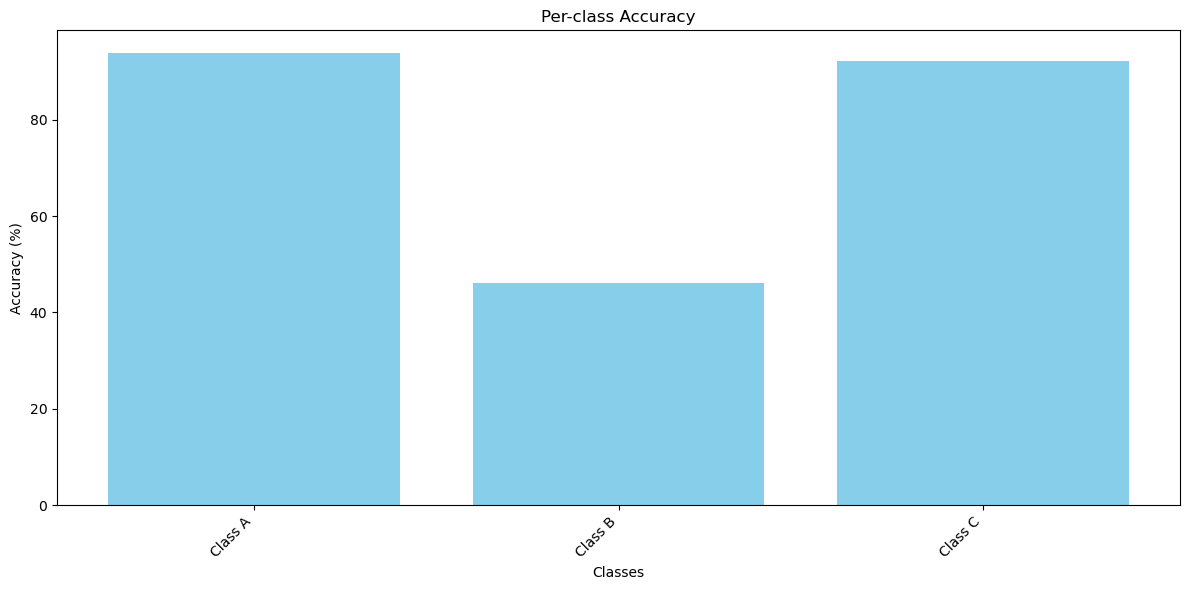

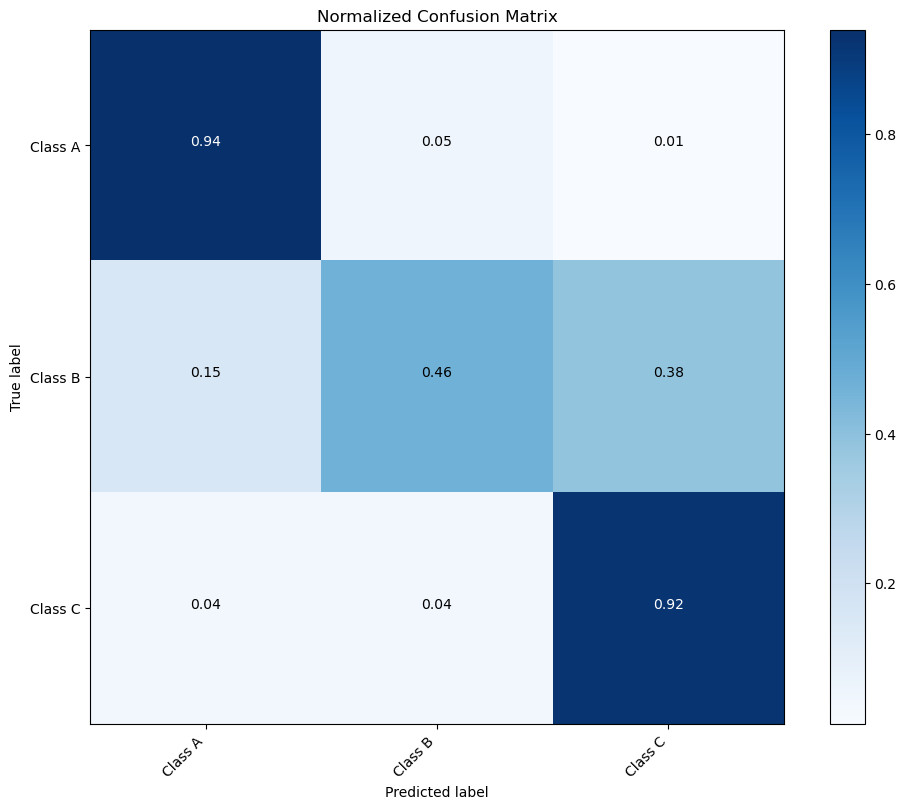

In [12]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, valloader)
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)